---
title: "🗓️ Week 05: Non-linear algorithms"
subtitle: "Theme: Supervised Learning"
author: "Dr. Ghita Berrada"
date: 21 February 2025
format: 
  html:
    from: markdown+emoji
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
jupyter: python3
engine: jupyter
bibliography:  ../../../../references/references.bib
editor:
  render-on-save: true
  preview: true
---

Welcome to Week 05! We wrap up our exploration of supervised learning this week.

But, let's start with some basic setup as usual...

# ⚙️ Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, fbeta_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels.api as sm
from lets_plot import *
LetsPlot.setup_html()
from lets_plot.plot import gggrid
from pytablewriter import MarkdownTableWriter
import matplotlib.pyplot as plt

# Part 1: Binary classification and its metrics

## 1.1 A quick look at our case study: loan outcome prediction

The dataset we're looking at today is a dataset from [Kaggle](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset/data).
It is 

> a collection of financial records and associated information used to determine the eligibility of individuals or organizations for obtaining loans from a lending institution. It includes various factors such as cibil score, income, employment status, loan term, loan amount, assets value, and loan status. This dataset is commonly used in machine learning and data analysis to develop models and algorithms that predict the likelihood of loan approval based on the given features. ^[[**Loan-Approval-Prediction-Dataset** Kaggle description page](https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset/data)].

So, the point of view we take in our classification is that of the lending institution. From its perspective, what do you think is more damageable: classifying rejected loans as approved or classifying approved loans as rejected?

Let's have a quick look at the dataset:

In [2]:
loans = pd.read_csv("../data/loan_approval_dataset.csv")

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


We can see that the dataset has 13 columns, most of which are numerical (only `education`, `self-employed` and `loan_status` are not) and that there are no missing values in this dataset.

Let's have a look at the distribution of credit scores:

In [4]:
loans.columns = loans.columns.str.strip() # remove leading/trailing spaces from column names
custom_palette = ['#2a9d8f', '#E76F51']  # Example: Persian Green & burnt sienna

# Plot histogram and density with matching colors
ggplot(loans, aes(x='cibil_score', fill='loan_status', color='loan_status')) + \
    geom_histogram(aes(y='..density..'), bins=30, alpha=0.5, position="identity") + \
    geom_density(size=1.2, alpha=0.7) + \
    scale_fill_manual(values=custom_palette) + \
    scale_color_manual(values=custom_palette) + \
    ggtitle("Credit Score Distribution by Loan Status") + \
    xlab("Credit Score") + \
    ylab("Density") + \
    theme_classic()

Now let's have a look the `education` and `self-employed` variables:

In [5]:
categorical_cols = ['education', 'self_employed']
loans[categorical_cols] = loans[categorical_cols].apply(lambda col: col.astype(str)) #convert type of columns with categorical data to string

# Create the education plot
plot_education = ggplot(loans, aes(x='education', fill='loan_status')) + \
    geom_bar(stat='count', position='dodge') + \
    scale_fill_manual(values=custom_palette) + \
    ggtitle("Count Plot of Education") + \
    xlab("Education") + \
    ylab("Count") + \
    theme_classic()

# Create a second plot for the self_employed category
plot_self_employed = ggplot(loans, aes(x='self_employed', fill='loan_status')) + \
    geom_bar(stat='count', position='dodge') + \
    scale_fill_manual(values=custom_palette) + \
    ggtitle("Count Plot of Self Employed") + \
    xlab("Self Employed") + \
    ylab("Count") + \
    theme_classic()

gggrid([plot_education, plot_self_employed], ncol=2)

## 1.2 Implementing binary classification models on the loan dataset

Our problem is predicting the outcome of the loan process (i.e whether the loan is rejected or approved) based on the data at hand. Our outcome variable is `loan_status`. Before it can be used as outcome variable, we'll need to label encode it (since values in that column are currently of type `object`).

Similarly we'll also label encode our categorical variables `education` and `self_employed` before we do our modeling.

In [6]:
categorical_cols = ['education', 'self_employed', 'loan_status']
for col in categorical_cols:
    encoder = LabelEncoder()
    loans[col] = encoder.fit_transform(loans[col])

**Training/test split**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(loans.drop(columns=['loan_id','loan_status'],axis=1),loans['loan_status'], stratify=loans['loan_status'],random_state=123)

We stratify by the outcome variable i.e loan status so that both training and test sets have the same proportions of both classes.

In [8]:
class_distribution = np.bincount(y_test) / len(y_test)
print("Class Imbalance (Proportions) - Test Set:")
print(f"Class 0 (Loan rejected): {class_distribution[0]:.2f}, Class 1 (Loan approved): {class_distribution[1]:.2f}")
class_distribution_train = np.bincount(y_train) / len(y_train)
print("Class Imbalance (Proportions) - Training Set:")
print(f"Class 0 (Loan rejected): {class_distribution_train[0]:.2f}, Class 1 (Loan approved): {class_distribution_train[1]:.2f}")

Class Imbalance (Proportions) - Test Set:
Class 0 (Loan rejected): 0.62, Class 1 (Loan approved): 0.38
Class Imbalance (Proportions) - Training Set:
Class 0 (Loan rejected): 0.62, Class 1 (Loan approved): 0.38


A quick check of class distribution in both training and test sets shows that the proportions of both classes are indeed identical in both sets. Furthermore, it shows that our dataset is imbalanced: we have more samples of loan rejections than of loans approvals in our dataset (as could probably be expected)!

I am training a logistic regression model as a baseline:

In [9]:
logit_model = LogisticRegression(max_iter=2000) 
logit_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

Next,  I generate predicted probabilities on both the training and testing sets from our logistic regression model using `predict_proba`.

In [10]:
# Generate predictions on the training set
train_probas = logit_model.predict_proba(X_train)[:,1]

# Generate predictions on the testing set
test_probas = logit_model.predict_proba(X_test)[:,1]

and convert the predicted probabilities to outcome predictions:

In [11]:
# Convert predicted scores to binary outcomes for the training set
train_preds = np.where(train_probas > 0.5, 1, 0)

# Convert predicted scores to binary outcomes for the testing set
test_preds = np.where(test_probas > 0.5, 1, 0)

The first metric I look at is the **confusion matrix** for both training and test sets i.e a graphical representation of counts from predicted and actual values

Quick reminder: 

- true positives are loans approved that are classified as approved
- true negatives are rejected loans that are classified as rejected
- false positives are rejected loans classified as approved
- false negatives are approved loans classified as rejected

This is likely an application where minimization false positive rates is a bit more important than minimizing false negative rates (since it increases default risk for the lender as opposed to reputational risk).

In [12]:
# Confusion Matrix for the training set
conf_matrix_train = confusion_matrix(y_train, train_preds)

# Extract TP, FP, FN, TN from confusion matrix
TN_train, FP_train, FN_train, TP_train = conf_matrix_train.ravel()

# Print the counts
print(f"True Negatives (TN): {TN_train}")
print(f"False Positives (FP): {FP_train}")
print(f"False Negatives (FN): {FN_train}")
print(f"True Positives (TP): {TP_train}")

# Convert confusion matrix to a DataFrame
conf_matrix_df_train = pd.DataFrame(
    conf_matrix_train, 
    columns=["Predicted 0", "Predicted 1"], 
    index=["Actual 0", "Actual 1"]
)

# Melt the confusion matrix DataFrame to long format
conf_matrix_long_train = conf_matrix_df_train.reset_index().melt(id_vars="index", value_vars=["Predicted 0", "Predicted 1"])
conf_matrix_long_train.columns = ["Actual", "Predicted", "Count"]

# Define a mapping of coordinates to labels
label_map = {
    ("Actual 0", "Predicted 0"): "TN",
    ("Actual 0", "Predicted 1"): "FP",
    ("Actual 1", "Predicted 0"): "FN",
    ("Actual 1", "Predicted 1"): "TP",
}

# Add annotations for TP, FP, FN, TN counts
conf_matrix_long_train['Annotation'] = conf_matrix_long_train.apply(
    lambda row: f"{label_map[(row['Actual'], row['Predicted'])]}: {row['Count']}", axis=1
)


# Create confusion matrix plot with Lets-Plot
conf_matrix_plot_train = ggplot(conf_matrix_long_train, aes(x='Predicted', y='Actual', fill='Count')) + \
    geom_tile() + \
    geom_text(aes(label='Annotation'), size=10, color='black', vjust=0.5, hjust=0.5) + \
    scale_fill_gradient(low='white', high='blue') + \
    ggtitle('Confusion Matrix') + \
    xlab('Predicted') + \
    ylab('Actual') + \
    coord_fixed(ratio=1) + \
    theme_minimal() + \
    theme(
        legend_position='right',
        plot_margin=0  # FIX: Remove element_blank() and use 0
    )

conf_matrix_plot_train

True Negatives (TN): 1818
False Positives (FP): 174
False Negatives (FN): 470
True Positives (TP): 739


How do we interpret this?

1. True Negatives (TN = 1818)

- Given that rejected loans make up 62% of the dataset, the model seems very good at predicting rejections, as expected for an imbalanced dataset.
- The model successfully rejects most bad loan applicants, which aligns with risk minimization.
- Given that 62% of loans in the dataset are rejections, this indicates strong risk control.
- However, TN alone does not mean the model is good, because a naive model that always predicts "Rejected" would still be correct 62% of the time.

2. False Positives (FP = 174)

- Only a small number of rejected loans were wrongly approved, which means the model is quite conservative and avoids risky approvals. The model rarely misclassifies high-risk applicants as low-risk, meaning it is careful in approving loans.
- Since the dataset has more rejected loans, keeping FP low is expected, but not necessarily a sign of good balance.
- The fact that our FP are low is a good outcome since we want to minimize FP. A lower FP count reduces financial risk, as it prevents bad loans from being approved. *If risk minimization is key, this is a positive sign.*

3. False Negatives (FN = 739)

- The model is incorrectly rejecting a large number of actually approved loans, which is a serious issue.
- Since only 38% of loans are actually approved, this high FN count suggests the model is biased towards rejecting loans, likely because of class imbalance.

4. True Positives (TP = 470)

- The model correctly approved 470 loans, which is very low considering that 38% of the dataset is approved loans.
- Many eligible customers are being denied loans. 

In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds)

# Extract TP, FP, FN, TN from confusion matrix
TN, FP, FN, TP = conf_matrix.ravel()

# Print the counts
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Convert confusion matrix to a DataFrame in long format for Lets-Plot
conf_matrix_df = pd.DataFrame(conf_matrix, columns=["Predicted 0", "Predicted 1"], index=["Actual 0", "Actual 1"])

# Melt the confusion matrix DataFrame to long format
conf_matrix_long = conf_matrix_df.reset_index().melt(id_vars="index", value_vars=["Predicted 0", "Predicted 1"])
conf_matrix_long.columns = ["Actual", "Predicted", "Count"]

# Define a mapping of coordinates to labels
label_map = {
    ("Actual 0", "Predicted 0"): "TN",
    ("Actual 0", "Predicted 1"): "FP",
    ("Actual 1", "Predicted 0"): "FN",
    ("Actual 1", "Predicted 1"): "TP",
}

# Add annotations for TP, FP, FN, TN counts
conf_matrix_long['Annotation'] = conf_matrix_long.apply(
    lambda row: f"{label_map[(row['Actual'], row['Predicted'])]}: {row['Count']}", axis=1
)

# Create confusion matrix plot with Lets-Plot
conf_matrix_plot = ggplot(conf_matrix_long, aes(x='Predicted', y='Actual', fill='Count')) + \
    geom_tile() + \
    geom_text(aes(label='Annotation'), size=10, color='black', vjust=0.5, hjust=0.5) + \
    scale_fill_gradient(low='white', high='blue') + \
    ggtitle('Confusion Matrix') + \
    xlab('Predicted') + \
    ylab('Actual') + \
    coord_fixed(ratio=1) + \
    theme_minimal() + \
    theme(
        legend_position='right',
        plot_margin=0  # FIX: Remove element_blank() and use 0
    )
    
conf_matrix_plot

True Negatives (TN): 609
False Positives (FP): 55
False Negatives (FN): 182
True Positives (TP): 222


In [14]:
precision_train=np.round(precision_score(y_train, train_preds), 3)
precision_test=np.round(precision_score(y_test, test_preds), 3)
recall_train=np.round(recall_score(y_train, train_preds), 3)
recall_test=np.round(recall_score(y_test, test_preds), 3)
print(f"Training set precision: {precision_train}")
print(f"Testing set precision: {precision_test}")
print(f"Training set recall: {recall_train}")
print(f"Testing set recall: {recall_test}")

# Calculate Balanced Accuracy
balanced_accuracy_train = np.round(balanced_accuracy_score(y_train, train_preds),3)
balanced_accuracy_test = np.round(balanced_accuracy_score(y_test, test_preds),3)

# Calculate F1-Score
train_f1 = np.round(f1_score(y_train, train_preds),3)
test_f1 = np.round(f1_score(y_test, test_preds),3)

train_fbeta = np.round(fbeta_score(y_train, train_preds, beta=0.5),3)
test_fbeta = np.round(fbeta_score(y_test, test_preds, beta= 0.5),3)



# Print all metrics
print(f"Balanced Accuracy (Train): {balanced_accuracy_train}")
print(f"Balanced Accuracy (Test): {balanced_accuracy_test}")

print(f"F1-Score (Train): {train_f1}")
print(f"F1-Score (Test): {test_f1}")

print(f"Fbeta-Score (Train): {train_fbeta}")
print(f"Fbeta-Score (Test): {test_fbeta}")

Training set precision: 0.809
Testing set precision: 0.801
Training set recall: 0.611
Testing set recall: 0.55
Balanced Accuracy (Train): 0.762
Balanced Accuracy (Test): 0.733
F1-Score (Train): 0.697
F1-Score (Test): 0.652
Fbeta-Score (Train): 0.76
Fbeta-Score (Test): 0.734


In [15]:
# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_probas)

# Create the ROC curve plot
roc_curve_data_train = pd.DataFrame({
    'fpr': fpr_train,
    'tpr': tpr_train
})

roc_curve_plot_train = ggplot(roc_curve_data_train, aes(x='fpr', y='tpr')) + \
                 geom_line(color='blue') + \
                 geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +  \
                 geom_abline(slope=0, intercept=1, linetype='solid', color='gray') +  \
                 ggtitle('ROC Curve') + \
                 xlab('False Positive Rate') + \
                 ylab('True Positive Rate') + \
                 coord_cartesian(xlim=(0, 1), ylim=(0, 1)) +\
                 theme_classic()

roc_curve_plot_train

In [16]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probas)

# Create the ROC curve plot
roc_curve_data = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})

roc_curve_plot = ggplot(roc_curve_data, aes(x='fpr', y='tpr')) + \
                 geom_line(color='blue') + \
                 geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +  \
                 geom_abline(slope=0, intercept=1, linetype='solid', color='gray') +  \
                 ggtitle('ROC Curve') + \
                 xlab('False Positive Rate') + \
                 ylab('True Positive Rate') + \
                 coord_cartesian(xlim=(0, 1), ylim=(0, 1)) +\
                 theme_classic()

roc_curve_plot

In [17]:
# Calculate AUC
train_auc = np.round(roc_auc_score(y_train, train_probas),3)
test_auc = np.round(roc_auc_score(y_test, test_probas),3)
print(f"AUC (Train): {train_auc}")
print(f"AUC (Test): {test_auc}")
# Calculate AUC-PR
train_auc_pr = round(average_precision_score(y_train, train_probas),3)
test_auc_pr = round(average_precision_score(y_test, test_probas),3)

print(f"AUC-PR (Train): {train_auc_pr}")
print(f"AUC-PR (Test): {test_auc_pr}")

AUC (Train): 0.881
AUC (Test): 0.88
AUC-PR (Train): 0.827
AUC-PR (Test): 0.816


In [18]:
writer = MarkdownTableWriter()
writer.table_name="Metrics table"
writer.headers=["Metric", "Training set", "Test set"]
writer.value_matrix=[
            ["Balanced accuracy"  ,  f"{balanced_accuracy_train}" ,f"{balanced_accuracy_test}"],
            ["Precision",f"{precision_train}",f"{precision_test}"],
            ["Recall",f"{recall_train}",f"{recall_test}"],
            ["F1_score",f"{train_f1}",f"{test_f1}"],
            ["Fbeta_score",f"{train_fbeta}",f"{test_fbeta}"],
            ["AUC",f"{train_auc}",f"{test_auc}"],
            ["AUC-PR",f"{train_auc_pr}",f"{test_auc_pr}"],
        ]
writer

# Metrics table
|     Metric      |Training set|Test set|
|-----------------|-----------:|-------:|
|Balanced accuracy|       0.762|   0.733|
|Precision        |       0.809|   0.801|
|Recall           |       0.611|   0.550|
|F1_score         |       0.697|   0.652|
|Fbeta_score      |       0.760|   0.734|
|AUC              |       0.881|   0.880|
|AUC-PR           |       0.827|   0.816|

**Interpretation**

1. *Balanced Accuracy*

*Balanced accuracy* adjusts for class imbalance by averaging the recall for both classes (loan rejected and loan approved).

More specifically, balanced accuracy is calculated as:

$$
    \begin{equation}
    \textrm{balanced}\_\textrm{accuracy}= \frac{sensitivity+specificity}{2}
    \end{equation}
$$

with 

$$
    \begin{align}
    \textrm{sensitivity} &= \frac{TP}{TP+FN}\\
              &= \frac{TP}{\textrm{all actual positives}}
    \end{align}
    $$
(sensitivity, also called recall - see below for more details - is the proportion of true positives among all actual positive cases)

and 

$$
    \textrm{specificity} = \frac{TN}{TN+FP}
$$

(i.e specificity is the proportion of negatives that are correctly identified as negatives)

The balanced accuracy is relatively high, which indicates that the model does well in predicting both classes, even with the class imbalance. The slight drop from the training to the test set suggests that the model generalizes well, though it might have slightly overfitted to the training data.

2. *Precision and recall*
   
*Precision* is the proportion of true positives among all the predicted positive cases.

$$
    \begin{align}
    \textrm{precision} &= \frac{TP}{TP+FP}\\
              &= \frac{TP}{\textrm{all predicted positives}}
    \end{align}
$$

It is a good metric when the cost of false positives is high, e.g spam detection (the consequences of misclassifying a legitimate email as spam can be significant as it may result in important communications being filtered out and so the cost of a false positive is higher than that of a false negative in this case).
   
*Precision* measures how many of the predicted positive cases (loan approved) are actually positive (true approvals). In other words, how accurate is the model when it predicts "loan approved"?

In our case, the precision is high, which indicates that, when the model predicts loan approval, it is right about 80% of the time. This suggests the model avoids false positives (predicting approval when it shouldn't). The model minimizes risk well and generalizes well to unseen data (barely any drop of performance between training and test sets).

*Recall (or sensitivity)* is the proportion of true positives among all actual positive cases.

$$
    \begin{align}
    \textrm{recall} &= \frac{TP}{TP+FN}\\
              &= \frac{TP}{\textrm{all actual positives}}
    \end{align}
$$

High recall is critical in applications where the cost of false negatives is high, e.g medical applications. For example, if thinking of predicting whether patients have diabetes or not, a false negative means a patient that has diabetes being misdiagnosed as being healthy which would result in delayed diagnosis and delayed appropriate treatment (and likely deterioration of the patient's condition in the meanwhile).

*Recall* measures how many of the actual positive cases (loan approved) were correctly identified by the model. In other words, how good is the model at capturing loan approvals?

The recall is lower, meaning the model misses around 40–50% of loan approvals. While it does a decent job on training data, recall drops slightly on the test set, which suggests some room for improvement in catching more true approvals.

1. *F1-score and Fbeta-score*

Most applications, though, will need a balance between precision and recall. That's where the F-score (especially in the form of the balanced F1-score) comes in: it's the harmonic mean of precision and recall.

$$
    \textrm{F1-score}=2\frac{precision * recall}{precision + recall}
    $$

A more general score $F_\beta$ exists if you want to emphasize precision over recall or vice versa. It is a weighted version of the F1 score, where you can adjust the weight (β) to emphasize either precision or recall:

$$
    \textrm{F}_{\beta}\textrm{-score} = (1+\beta^2)\frac{precision * recall}{(\beta^2.precision)+ recall}
$$


The model performs moderately well in terms of F1-score, but the drop from the training set to the test set suggests that the model's ability to balance precision and recall is not perfect, especially in unseen data.

Here, we've computed the F$_{\beta}$ score so as to emphasize precision (i.e false positives) over recall (i.e false negatives), in other words to emphasize risk minimization over increasing loan approvals.

The fact that F$_{\beta}$ is higher than F1 shows that the model is doing relatively well in terms of precision (ensuring most of the predicted approvals are true approvals). But, there is still a drop in performance from the training to the test set, which suggests a slight overfitting issue. However, both the training and test Fβ scores are still fairly high, indicating that the model is good at making correct approval decisions (precision), though it might miss some true approvals due to the emphasis on minimizing false positives.

1. *ROC curve and AUC*

The ROC curve is a plot of the true positive rate - $TPR$- (recall) against the false positive rate ($FPR$).

The false positive rate is defined as follows:

$$
\begin{align}
\textrm{FPR} &= \frac{FP}{FP+TN}\\
    &= \frac{FP}{\textrm{all actual negatives}}\\
    &= 1-specificity
\end{align}
$$

It is a good metric when you want to visualise the trade-off between precision and recall. It's **a visual representation of model performance across all thresholds.**

Here is what it looks like for our classifier first for the training then the test set:

In [ ]:
# Compute ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, train_probas)

# Create the ROC curve plot
roc_curve_data_train = pd.DataFrame({
    'fpr': fpr_train,
    'tpr': tpr_train
})

roc_curve_plot_train = ggplot(roc_curve_data_train, aes(x='fpr', y='tpr')) + \
                 geom_line(color='blue') + \
                 geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +  \
                 geom_abline(slope=0, intercept=1, linetype='solid', color='gray') +  \
                 geom_vline(xintercept=1, linetype='solid', color='gray') + \
                 ggtitle('ROC Curve (Training set)') + \
                 xlab('False Positive Rate') + \
                 ylab('True Positive Rate') + \
                 coord_cartesian(xlim=(0, 1), ylim=(0, 1)) +\
                 theme_classic()

roc_curve_plot_train

In [20]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probas)

# Create the ROC curve plot
roc_curve_data = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr
})

roc_curve_plot = ggplot(roc_curve_data, aes(x='fpr', y='tpr')) + \
                 geom_line(color='blue') + \
                 geom_abline(slope=1, intercept=0, linetype='dashed', color='gray') +  \
                 geom_abline(slope=0, intercept=1, linetype='solid', color='gray') +  \
                 geom_vline(xintercept=1, linetype='solid', color='gray') + \
                 ggtitle('ROC Curve (Test set)') + \
                 xlab('False Positive Rate') + \
                 ylab('True Positive Rate') + \
                 coord_cartesian(xlim=(0, 1), ylim=(0, 1)) +\
                 theme_classic()

roc_curve_plot

As a baseline, a random classifier is expected to give points lying along the diagonal ($FPR=TPR$).

Classifiers that give curves closer to the top-left corner indicate a better performance, since it means high recall with low false positives.The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

*In our case, for both training and test sets, he blue ROC curve is well above the diagonal (dashed gray line), which means the model performs significantly better than random guessing.*

A metric that goes along the ROC curve is the AUC (Area Under the Curve) metric. The AUC is a metric that measures the performance of a model across all classification thresholds. The closer to 1, the better the model: a random classifier is one whose ROC lies on the diagonal $FPR=TPR$ and its AUC would be 0.5. It is a good metric when you want to compare models across different thresholds.

ROC curves and AUC are good metrics when you care equally about positive and negative classes. They tend to overestimate model performance in case of heavy class imbalance.

The AUC score measures the ability of the model to distinguish between the classes (loan rejected vs. loan approved). A score of 1 indicates perfect classification, while 0.5 means the model is guessing randomly.

The AUC score is quite high, meaning the model has excellent discrimination ability between the two classes, even with the class imbalance. The AUC is very stable between the training and test sets, suggesting no major overfitting issues in terms of distinguishing between loan approval and rejection.

5. *Precision-recall curve*

Much like the ROC curve, the precision-recall curve is used for evaluating the performance of binary classification algorithms: it is a plot of precision against recall. Much like the ROC curve, it's **a visual representation of model performance across all thresholds.** 

Why would we use the precision-recall curve? 

ROC curves/AUC tend to overestimate model performance in case of heavy class imbalance. Precision-recall curves and the AUC-PR (i.e the area under the precision-recall curve) are good metrics in such a case. The intuition is that AUC-PR focuses mainly on the positive class and therefore cares less about the frequent negative class, making it more suitable in case of heavy imbalance.

By the same token, using precision-recall curves and AUC-PR is also a good idea when you care more about the positive class than the negative class.

In [ ]:
# Compute Precision-Recall curve
precision_train, recall_train, _ = precision_recall_curve(y_train, train_probas)

# Create the Precision-Recall curve plot
pr_curve_data_train = pd.DataFrame({
    'recall': recall_train,
    'precision': precision_train
})

pr_curve_plot_train = ggplot(pr_curve_data_train, aes(x='recall', y='precision')) + \
                geom_line(color='green') + \
                ggtitle('Precision-Recall Curve (Training set)') + \
                xlab('Recall') + \
                ylab('Precision') + \
                theme_classic()

pr_curve_plot_train

In [19]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, test_probas)

# Create the Precision-Recall curve plot
pr_curve_data = pd.DataFrame({
    'recall': recall,
    'precision': precision
})

pr_curve_plot = ggplot(pr_curve_data, aes(x='recall', y='precision')) + \
                geom_line(color='green') + \
                ggtitle('Precision-Recall Curve (Test set)') + \
                xlab('Recall') + \
                ylab('Precision') + \
                theme_classic()

pr_curve_plot

- High Precision at Low Recall (Left Side of the Curve)

At the start, the model has very high precision (~1.0) but low recall.
This means that when the model does approve a loan, it is almost always correct (very few false approvals).
However, it rejects many eligible applicants because recall is low.

- Precision Decreases as Recall Increases

As the model tries to capture more true approvals (higher recall), precision gradually declines.
This happens because approving more loans increases the risk of false approvals (i.e., approving applicants who may default).
The curve maintains decent precision (above 0.7–0.8) until recall becomes very high (>0.8).

- Sharp Drop at High Recall (Right Side of the Curve)

At very high recall values (~0.9–1.0), precision drops sharply.
This means that when the model tries to approve almost everyone, it loses precision and starts approving many bad loans.
Business Impact: If the model is too lenient, it may approve high-risk loans that could lead to defaults.

Similarly to AUC, you can compute the area under precision-recall curve i.e AUC-PR. Here is how you would interpret AUC-PR:

- AUC-PR ≈ 1.0 → Excellent model; approves many loans with high accuracy
- AUC-PR > 0.75 → Good model; balances approvals while avoiding risky approvals
- AUC-PR ~ 0.5 → Performs only slightly better than random guessing.
- AUC-PR < 0.5 → Model is poor; it may approve many bad loans or reject too many good ones

In our case, AUC-PR is slightly above 0.8 for both training and test sets. This means that:

- if the model predicts a loan approval, there’s a high probability it is correct
- the model performs well in identifying loan approvals, meaning it can balance precision (avoiding bad loans) and recall (approving good loans) effectively and it successfully balances risk and opportunity in loan approvals
- The model does not heavily over-reject applicants, which is important for financial institutions aiming to maximize loan approvals without excessive risk
- The small difference in performance between training and test set (only 0.011 or 1.3%) indicates that the model generalizes well and there is no significant overfitting, meaning the model isn’t just memorizing the training data—it’s also working well on new (unseen) data

## 1.3 A recap of the metrics

| **Metric**            | **Description**                                                                                      
|-------------------|----------------------|
| Accuracy              | Proportion of correct predictions                                                                    |
| Sensitivity (=recall) | The proportion of positive results out of the number of samples that were actually positive.          |
| Specificity           | The proportion of negatives that are correctly identified as negatives.                               | 
| Precision             | The proportion of true positive results out of the number of samples that were predicted as positive. | 
| Recall (=sensitivity) | The proportion of true positive results out of the number of samples that were actually positive.     | 
| F1 score             | The harmonic mean of precision and recall.                                                            | 
| F$_{\beta}$ score             | Weighted harmonic mean of precision and recall (emphasizes either precision or recall)                                                           | 
| ROC Curve             | Plot of recall/true positive rate ($TPR$) against false positive rate ($FPR$)                         |
| AUC                   | Area under the ROC curve                                                                              |
| Precision-recall curve                   | Plot of precision against recall/true positive rate ($TPR$)                   |
| AUC-PR                   | Area under the precision-recall curve                                                                              |
| Balanced accuracy     | Mean of sensitivity and specificity                                                                   | 


# Part 2: Non-linear models

## 2.1 The case for non-linear models

❓ Why do we use linear models?

-   Linear and logistic regression are a good first shot for building ML model

    -   Easy-to-interpret coefficients
    -   Intuitive (ish) ways to assess variable importance
    -   Often good out-of-the-box prediction

-   However...

    -   Assumption that the predictors are linearly related to the outcome is restrictive
    -   Sometimes, accounting for higher order polynomial relationships or other non-linear relationships can produce better model fit
  
:::callout-note
Logistic regression is considered a **generalized linear model** as it models log-odds as a linear function of the input features

$$ \log(\frac{1−P(Y=1)}{P(Y=1)})=w\mathbf{X}+b$$
:::

Let's take a look at a quick example: the `Wage` dataset (in the `statsmodels.api.datasets` library) which provides income survey data for men in the central Atlantic region of the USA. Let's load the dataset and have a very quick look at it

In [21]:
wage = sm.datasets.get_rdataset("Wage", "ISLR").data
wage.head()

year  age            maritl      race        education  \
rownames                                                           
231655    2006   18  1. Never Married  1. White     1. < HS Grad   
86582     2004   24  1. Never Married  1. White  4. College Grad   
161300    2003   45        2. Married  1. White  3. Some College   
155159    2003   43        2. Married  3. Asian  4. College Grad   
11443     2005   50       4. Divorced  1. White       2. HS Grad   

                      region        jobclass          health health_ins  \
rownames                                                                  
231655    2. Middle Atlantic   1. Industrial       1. <=Good      2. No   
86582     2. Middle Atlantic  2. Information  2. >=Very Good      2. No   
161300    2. Middle Atlantic   1. Industrial       1. <=Good     1. Yes   
155159    2. Middle Atlantic  2. Information  2. >=Very Good     1. Yes   
11443     2. Middle Atlantic  2. Information       1. <=Good     1. Yes   

           logwage        wage  
rownames                        
231655    4.318063   75.043154  
86582     4.255273   70.476020  
161300    4.875061  130.982177  
155159    5.041393  154.685293  
11443     4.318063   75.043154

In this dataset, we are particularly interested in the relationship between `age` and `wage`.

In [22]:
# Create scatter plot
ggplot(wage, aes(x="age", y="wage")) + geom_point(alpha=0.2)

Looking at this plot, we see that the relationship is likely not linear... And in this case, we fit a polynomial of degree 4 to this data (for more details, on this example and polynomial interpolations, see chapter 7 of [@james_introduction_2023]).

In [23]:
# Prepare the polynomial features (degree 4)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(wage[['age']])

# Create a linear regression model
model = LinearRegression()
model.fit(X_poly, wage['wage'])

# Make predictions on the original data
wage['pred'] = model.predict(X_poly)

# Create a new dataset for the age range prediction
age_range = np.linspace(wage['age'].min(), wage['age'].max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(age_range)
predictions = model.predict(X_range_poly)

# Estimate 95% confidence intervals (using the standard error)
std_err = np.std(wage['wage'] - wage['pred'])  # Estimate residual std dev
lower_bound = predictions - 1.96 * std_err
upper_bound = predictions + 1.96 * std_err

# Create a dataframe for plotting
regression_lines = pd.DataFrame({
    'age': age_range.flatten(),
    'pred': predictions,
    'pred_lower': lower_bound,
    'pred_upper': upper_bound
})

# Plotting using lets_plot
ggplot(wage, aes(x='age', y='wage')) + \
    geom_point(alpha=0.2) + \
    geom_line(aes(x='age', y='pred'), data=regression_lines, color='darkgreen') + \
    geom_line(aes(x='age', y='pred_lower'), data=regression_lines, color='blue', linetype='dashed') + \
    geom_line(aes(x='age', y='pred_upper'), data=regression_lines, color='blue', linetype='dashed')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


:::callout-note
When constructing a confidence interval for a regression model’s predictions, you typically use the standard error of the predictions. The confidence interval is then defined as:

$$ \textrm{Prediction} \pm 𝑍 × \textrm{Standard Error}$$

Where:

$\textrm{Prediction}$ is the predicted value from the model.
$Z$ is a value from the $Z$-distribution (the standard normal distribution) corresponding to the desired level of confidence. 
For a 95% confidence interval, the $Z$-value is approximately 1.96 (this value is derived from the standard normal distribution, where 95% of the data lies within 1.96 standard deviations of the mean).
$\textrm{Standard Error}$ is the standard deviation of the residuals (or errors) of the model.

Why 1.96?

For a 95% confidence interval, 95% of the data in a standard normal distribution lies within $\pm1.96$ standard deviations of the mean. Therefore, 1.96 is the multiplier used to get the upper and lower bounds of the confidence interval. If you were constructing a 99% confidence interval, for instance, you would use a $Z$-value of approximately 2.58 (this corresponds to 99% of the distribution).

:::

## 2.2 K-NN

The first non-linear model we'll look at is $K$-Nearest neighbours or $K$-NN.
$K$-NN is used for both classification and regression.

### 2.2.1 What is K-NN?

**Basic idea (images and example from [here](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)):**

Look at this example. Say you want to predict the class of the blue star (BS) and see whether it's a red circle (RC) or a green square (GS).

![](images/paste-1.png)

$K$-NN will take "votes" from the nearest neighbours (nearest defined based on pre-specified distance usually Euclidian distance) and will only look at $K$ neighbours (hence the $K$ in $K$-NN).

In this case, if we take $K=3$, we see that the blue star is surrounded by 3 red circles and no green squares, so the star would be classified as a red circle.

![](images/paste-2.png)

**K-NN: the steps**

1.  Load the data

2.  Initialise the value of \$K\$

3.  To get the predicted class, iterate over the test data points

    -   Calculate the distance between test data point and each row of the training set. By default, use the Euclidian distance. Other distance metrics that could be used are the Manhattan distance, Minkowski distance, Chebyshev, cosine, etc. If there are categorical variables, the Hamming distance can be used.

    -   Sort the calculated distances in ascending order based on distance values

    -   Get top $K$ rows from the sorted array of distances

    -   Get the most frequent class from these rows

    -   Return the most frequent class as the predicted class for the current test data point

### $K$-NN applied to loan prediction

Let's go back to our loan prediction problem and apply $K$-NN.

Before applying $K$-NN, we need to standardize our data since it is a distance-based method so sensitive to scale and outliers (if we don't, features with a large scale would be overemphasized in the classification!).

In [24]:
numerical_features = [col for col in loans.columns if col not in ['education', 'self_employed', 'loan_status','loan_id']]

# Initialize scaler
scaler = StandardScaler()
# Scale numerical features
scaled_values = scaler.fit_transform(loans[numerical_features])

# Create a new DataFrame with scaled numerical features
loans_scaled = pd.DataFrame(scaled_values, columns=numerical_features, index=loans.index)

# Add back the categorical features and target variable
loans_scaled[['education', 'self_employed', 'loan_status']] = loans[['education', 'self_employed', 'loan_status']]

# Display the first few rows
print(loans_scaled.head())

   no_of_dependents  income_annum  loan_amount  loan_term  cibil_score  \
0         -0.294102      1.617979     1.633052   0.192617     1.032792   
1         -1.473548     -0.341750    -0.324414  -0.508091    -1.061051   
2          0.295621      1.439822     1.610933   1.594031    -0.544840   
3          0.295621      1.119139     1.721525  -0.508091    -0.771045   
4          1.475067      1.689242     1.002681   1.594031    -1.264055   

   residential_assets_value  commercial_assets_value  luxury_assets_value  \
0                 -0.780058                 2.877289             0.832028   
1                 -0.733924                -0.631921            -0.694993   
2                 -0.057300                -0.107818             1.996520   
3                  1.649637                -0.381263             0.897943   
4                  0.757724                 0.735304             1.568075   

   bank_asset_value  education  self_employed  loan_status  
0          0.930304          0 

In [26]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(loans_scaled.drop(columns=['loan_status'],axis=1),loans_scaled['loan_status'], stratify=loans['loan_status'],random_state=123)

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_scaled, y_train_scaled)

# Predict on test data
y_pred_test_knn = knn_model.predict(X_test_scaled)
y_pred_train_knn = knn_model.predict(X_train_scaled)

In [28]:
balanced_accuracy_train_knn = round(balanced_accuracy_score(y_train, y_pred_train_knn),3)
balanced_accuracy_test_knn = round(balanced_accuracy_score(y_test, y_pred_test_knn),3)
precision_train_knn = round(precision_score(y_train, y_pred_train_knn),3)
precision_test_knn = round(precision_score(y_test, y_pred_test_knn),3)
recall_train_knn = round(recall_score(y_train, y_pred_train_knn),3)
recall_test_knn = round(recall_score(y_test, y_pred_test_knn),3)
f1_train_knn = round(f1_score(y_train, y_pred_train_knn),3)
f1_test_knn = round(f1_score(y_test, y_pred_test_knn),3)
fbeta_train_knn = round(fbeta_score(y_train, y_pred_train_knn,beta=0.5),3)
fbeta_test_knn = round(fbeta_score(y_test, y_pred_test_knn,beta=0.5),3)
auc_pr_train_knn = round(average_precision_score(y_train, y_pred_train_knn),3)
auc_pr_test_knn = round(average_precision_score(y_test, y_pred_test_knn),3)

writer = MarkdownTableWriter()
writer.table_name="Metrics table"
writer.headers=["Metric", "Training set", "Test set"]
writer.value_matrix=[
            ["Balanced accuracy"  ,  f"{balanced_accuracy_train_knn}" ,f"{balanced_accuracy_test_knn}"],
            ["Precision",f"{precision_train_knn}",f"{precision_test_knn}"],
            ["Recall",f"{recall_train_knn}",f"{recall_test_knn}"],
            ["F1_score",f"{f1_train_knn}",f"{f1_test_knn}"],
            ["Fbeta_score",f"{fbeta_train_knn}",f"{fbeta_test_knn}"],
            ["AUC-PR",f"{auc_pr_train_knn}",f"{auc_pr_test_knn}"],
        ]
writer

# Metrics table
|     Metric      |Training set|Test set|
|-----------------|-----------:|-------:|
|Balanced accuracy|       0.915|   0.834|
|Precision        |       1.000|   0.934|
|Recall           |       0.830|   0.698|
|F1_score         |       0.907|   0.799|
|Fbeta_score      |       0.961|   0.875|
|AUC-PR           |       0.894|   0.766|

What do these metrics tell us?


| **Metric**             | **Training Set** | **Test Set**  | **Interpretation**  |
|----------------------|----------------|--------------|----------------|
| **Balanced Accuracy** | 0.915 | 0.834 | ✅ **Good overall classification performance.** The model correctly classifies both approved and rejected loans far better than random (0.5). |
| **Precision** | 1.000 | 0.934 | 🚀 **Extremely high precision** on both sets. When the model predicts a loan is approved, it's right most of the time. **Low false positives** (very few rejected loans wrongly classified as approved). |
| **Recall** | 0.830 | 0.698 | ⚠️ **Decent but lower recall on test set.** Some approved loans are still misclassified as rejected, meaning the model is **conservative in approvals** (i.e the lender is risk-averse). |
| **F1-score** | 0.907 | 0.799 | ✅ **Balanced trade-off between precision and recall.** Test set shows some drop, meaning the model generalizes well but not perfectly. |
| **Fβ-score** (precision emphasised) | 0.961 | 0.875 | ✅ **High emphasis on precision.** The model prioritizes **avoiding false approvals**, making it more conservative. |
| **AUC-PR** | 0.894 | 0.766 | 🎯 **Strong ability to rank positive cases correctly.** Still, the test AUC-PR is **lower than training**, meaning some overfitting. |

- **Precision is very high (0.934 on test set)** → The model **rarely makes false approvals** (loans wrongly approved).  
- **Recall is lower (0.698 on test set)** → The model **misses some actual approvals**, meaning some **good applicants are denied**.  
- **AUC-PR = 0.766 on test set** → The model still performs **significantly better than random guessing (0.38)**, indicating strong predictive power.  
-  **Overfitting Signs:**  
   - Training vs. test scores drop (e.g., recall 0.830 → 0.698, AUC-PR 0.894 → 0.766).  
   - This suggests K-NN (with k=2) might be **too sensitive** to training data, and a slightly higher `k` could improve generalization.




### 2.2.3 A note about overfitting/underfitting

We kept mentioning **overfitting** when referring to the performance of both models. So what is it? Simply put, **overfitting** happens when the model fits to the training data too closely and doesn't generalize well to the test data, i.e when you've built a model which is too complex for the data.

**Underfitting**, on the flip side, occurs when you have a model that is too simple and can't capture the relationship between input and output variables in the dataset, e.g if you fit a linear regression where a polynomial regression of a higher order would be more appropriate (for instance, in the `Wage` example we saw earlier)

Once we're done with training our model (e.g linear/logistic regression or $K$-NN), we need to evaluate its out-of-sample performance.

We could do that on a test set but:

-   what if we have limited data?
-   what if we're not sure the test set has a similar distribution than the training set?

Simply, using a single training/test set split is not enough to produce a generalizable model.

What if we're also unsure of what hyperparameter to select for our model (e.g $\lambda$ in LASSO or $K$ in $K$-NN?) 

Enters cross-validation.

## 2.2.4 A note about cross-validation

What is cross-validation, also called $K$-fold cross validation?

$K$-Fold cross-validation is a resampling procedure used to evaluate models on limited data:
    -   the data is randomly split into $K$ equal-sized subsamples on which the model is then evaluated ($K$ is usually set as 5 or 10)
    -   the performance of the model is averaged over those subsamples
    -   this makes for a less biased performance since all data would have been seen
  


![Source:https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif](../../../../2024/autumn-term/download/KfoldCV.gif)

**Quick examples of applying cross-validation**

*Cross-validation with Logistic Regression without parameter tuning*

In [29]:
log_reg = LogisticRegression(max_iter=1000)  # Increase iterations to ensure convergence

# Perform 5-fold cross-validation using AUC-PR as the scoring metric
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='average_precision')

print("AUC-PR Scores for each fold:", cv_scores)
print("Mean AUC-PR Score:", round(cv_scores.mean(),3))

AUC-PR Scores for each fold: [0.84557356 0.81636976 0.81571092 0.85743134 0.80359882]
Mean AUC-PR Score: 0.828


Logistic regression scores an AUC-PR of 0.828 on average. A random classifier (guessing randomly) would have an AUC-PR equal to the positive class proportion, which in this case is 0.38 (since 38% of loans are approved). Our model’s 0.828 AUC-PR is much higher than 0.38, meaning it significantly outperforms random guessing in identifying approved loans and performs well in distinguishing the minority class (approved loans) from the majority class (rejected loans).

*Cross-validation with $K$-NN with parameter tuning*

In [30]:
param_grid = {'n_neighbors': [2, 5, 6, 8, 12]}

grid_search = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid, 
    cv=5, 
    scoring='average_precision'  # Optimizing AUC-PR instead of AUC-ROC
)

grid_search.fit(X_train_scaled, y_train_scaled)

# Best hyperparameter based on AUC-PR
print("Best n_neighbors:", grid_search.best_params_)
print("Best AUC-PR Score:", round(grid_search.best_score_,3))

Best n_neighbors: {'n_neighbors': 12}
Best AUC-PR Score: 0.946


The $K$-NN model achieves an optimal AUC-PR = 0.946 for $K=12$. This is a very strong performance, especially for an imbalanced dataset where only 38% of loans are approved. The model is far better than random and has excellent predictive power. The model is very good at approving truly good loans (high precision). It also captures a fair amount the actual approvals (good recall). 

AUC-PR from cross-validation is a more robust estimate than a single test set result. This suggests that the model will likely perform well on unseen loan applications.

K-NN (0.946) clearly outperforms Logistic Regression (0.828) in AUC-PR, meaning it's better at distinguishing approved vs. rejected loans.
Logistic Regression is still quite strong (AUC-PR = 0.828 is solid), but it may struggle with complex patterns that K-NN captures.

However, if interpretability is important, you may to go for logistic regression instead!


## 2.3 Support Vector Machines (SVM)

Yet, another model we'll be looking at is Support Vector Machines (SVM).

SVM are mainly used for classification, though they are sometimes also used for regression tasks.

### 2.3.1 Principle of SVM 

Consider this example from the famous Iris dataset with two easily separated classes of of Iris flowers (according to their sepal width and sepal length characteristics)...Colours in the plots represent distinct species...

In [31]:
# Load the Iris dataset from statsmodels
iris = sm.datasets.get_rdataset('iris').data

# Filter out the "versicolor" species
iris_filtered = iris[iris["Species"] != "versicolor"]

# Create the plot
p = ggplot(iris_filtered) + \
    geom_point(aes(x='Sepal.Length', y='Sepal.Width', color='Species')) 

# Show the plot
p.show()

The goal here is to find the line (hyperplane in dimensions higher than 2) that best separates our classes (not necessarily simply two classes). There is obviously an infinity of hyperplanes separating the classes.

In [32]:
# Create the base plot with points only
p = ggplot(iris_filtered) + \
    geom_point(aes(x='Sepal.Length', y='Sepal.Width', color='Species'))

# Add segments with direct coordinate specification
p = p + \
    geom_segment(x=4.4, y=2, xend=6.5, yend=4.5, color="black", linetype="dashed", alpha=0.7) + \
    geom_segment(x=5, y=2, xend=6.5, yend=4, color="black", linetype="dashed", alpha=0.7) + \
    geom_segment(x=4, y=2, xend=7, yend=4.5, color="black", linetype="dashed", alpha=0.7)

# Show the plot
p

SVM chooses the one that maximises the margin (i.e the distance) between the classes.

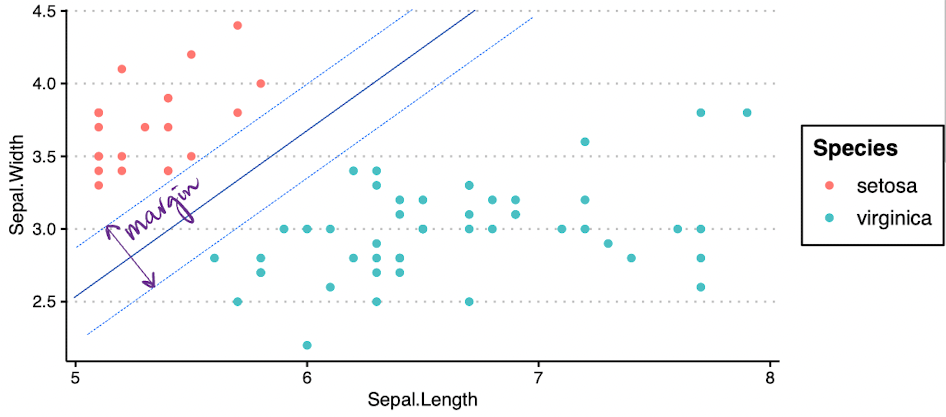

Note that the separation does not have to be linear. If the classes can't be separated linearly, we apply the so-called kernel trick (i.e we transform the data with a function called a kernel, which is often equivalent to projecting the data onto a higher dimension), so as to make it separable.

### 2.3.2 Back to our case study

SVMs require a bit of pre-processing to be applied to the data before the model (they can't deal with categorical variables out-of-the box, require normalization and have issues with missing values).

So, we'll apply it (just like we did with $K$-NN on the scaled data).

In [33]:
# 1. Linear SVM
linear_svm = SVC(kernel='linear', random_state=42)

# Cross-validation for Linear SVM
linear_svm_cv = cross_val_score(linear_svm, X_train_scaled, y_train, cv=5, scoring='average_precision')  # Using AUC-PR as evaluation metric
print(f"Linear SVM - Cross Validation AUC-PR: {round(linear_svm_cv.mean(),3)}")

# 2. RBF SVM
rbf_svm = SVC(kernel='rbf', random_state=42)

# Cross-validation for RBF SVM
rbf_svm_cv = cross_val_score(rbf_svm, X_train_scaled, y_train, cv=5, scoring='average_precision')  # Using AUC-PR as evaluation metric
print(f"RBF SVM - Cross-validation AUC-PR: {round(rbf_svm_cv.mean(),3)}")

# 3. Polynomial SVM
poly_svm = SVC(kernel='poly', degree=3, random_state=42)  # Degree 3 polynomial kernel

# Cross-validation for Polynomial SVM
poly_svm_cv = cross_val_score(poly_svm, X_train_scaled, y_train, cv=5, scoring='average_precision')  # Using AUC-PR as evaluation metric
print(f"Polynomial SVM - Cross-validation AUC-PR: {round(poly_svm_cv.mean(),3)}")

Linear SVM - Cross Validation AUC-PR: 0.934
RBF SVM - Cross-validation AUC-PR: 0.973
Polynomial SVM - Cross-validation AUC-PR: 0.939


The performance of the linear kernel SVM confirms, just as we saw with logistic regression, that while a linear model still performs strongly on this dataset (likely due to the the clean nature of it!), it still doesn't capture the complexity of the data as well as non-linear models.
The clear winner here is the radial basis function kernel SVM, which even outperforms our tuned $K$-NN model.

Could we make these SVM models better? Yes, by tuning their hyperparameters (e.g degree of the polynomial for the polynomial kernel or cost parameter which penalizes classification errors).

One shortcoming of SVMs is they're not very interpretable. You would need post-hoc explainability techniques such as Shapley values ^[Scott M. Lundberg and Su-In Lee. 2017. *A unified approach to interpreting model predictions*. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 4768–4777 .[https://dl.acm.org/doi/10.5555/3295222.3295230](https://dl.acm.org/doi/10.5555/3295222.3295230)] or LIME ^[Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin. 2016. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 1135–1144. [https://doi.org/10.1145/2939672.2939778](https://doi.org/10.1145/2939672.2939778)] to make them interpretable.

## 2.4 Tree-based methods

### Decision Trees

Trees, on the other hand, are inherently explainable methods. But, we'll see why after fitting a tree model to our data.

Unlike with SVMs, pre-processing is minimal. Trees can handle mixed types of data (categorical data included) fairly well and are tolerant to missing values. Like many other methods, they are affected by the curse of dimensionality, i.e data of large dimensions (too many data points and/or features). We'll see, in W07, how to overcome that.

Cross-validated AUC-PR: 0.947 ± 0.013


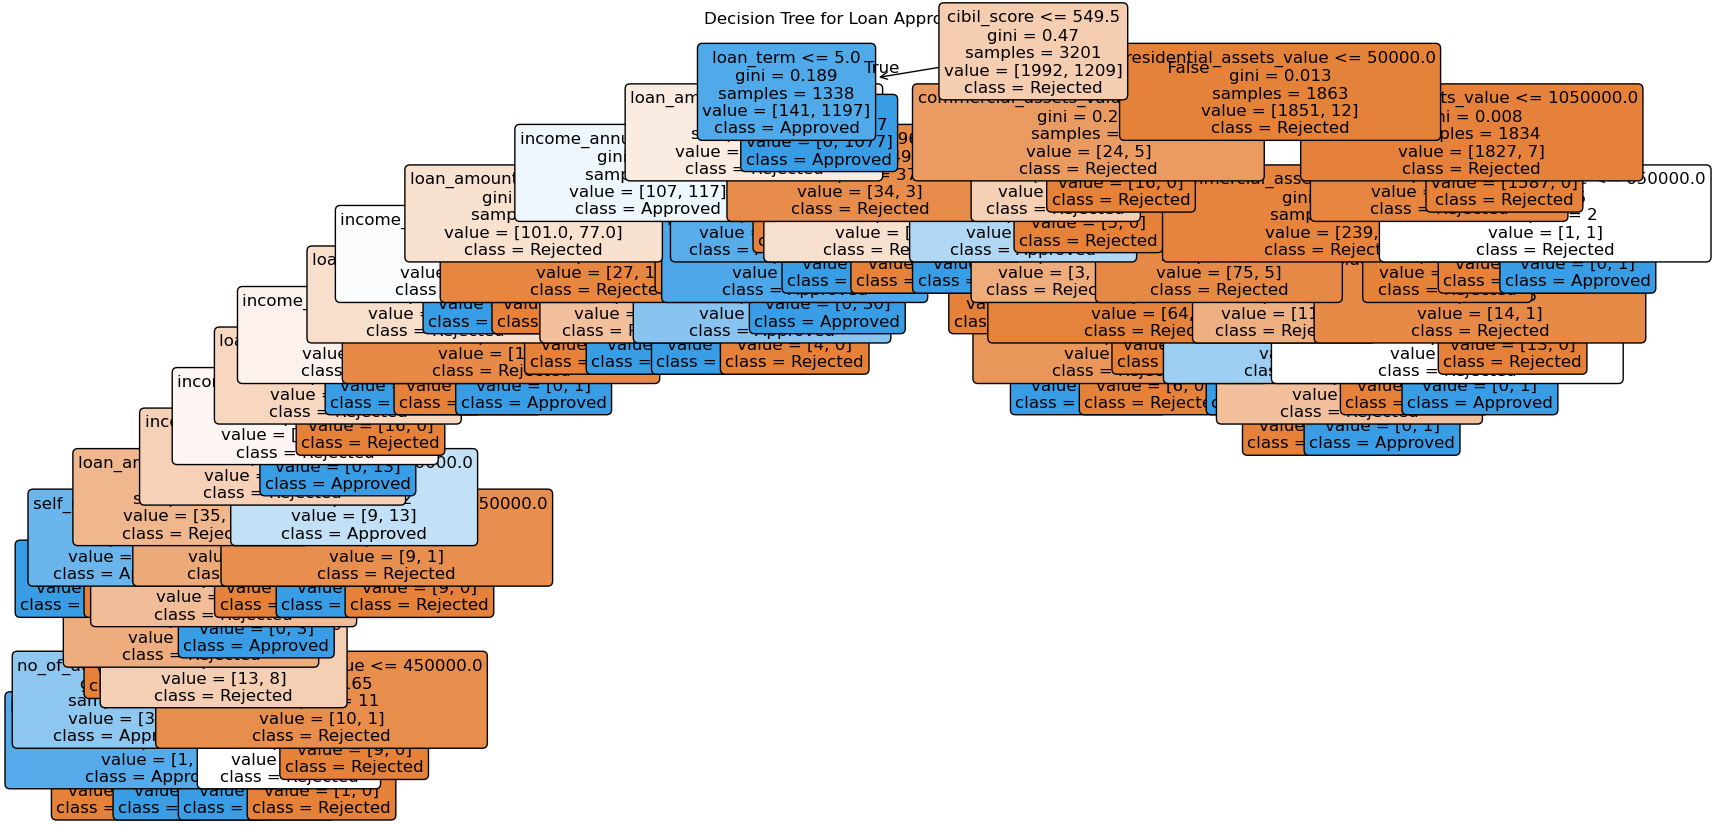

In [34]:
dtree = DecisionTreeClassifier(random_state=42)
cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring="average_precision")

print(f"Cross-validated AUC-PR: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 2. Fit the Decision Tree on the entire training data
dtree.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dtree, filled=True, feature_names=X_train.columns, class_names=["Rejected", "Approved"], rounded=True, fontsize=12)
plt.title("Decision Tree for Loan Approval")
plt.show()

On the face of it (cross-validated AUC-PR metric), the performance of our tree is on par with $K$-NN. 

The tree looks, however, extremely complex! This is a sign of **overfitting**. You can simplify the decision tree by controlling its complexity using parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf`. These parameters allow you to restrict the tree's growth, preventing it from becoming too complex and overfitting to the data.

Here’s how you can simplify the decision tree:

- `max_depth`: Limits the depth of the tree. A smaller depth will result in a simpler tree.
- `min_samples_split`: Sets the minimum number of samples required to split an internal node. Increasing this value can prevent the tree from splitting too often.
- `min_samples_leaf`: Sets the minimum number of samples required to be at a leaf node. Increasing this value will make the tree simpler by forcing it to merge smaller groups.

## What's going on behind the scenes?

How decision trees work:

<div>

-   Divide the predictor space into $\mathbf{J}$ distinct regions $R_1$, $R_2$,...,$R_j$.
-   Take the mean of the response values in each region

</div>

Let's take a closer look through the Iris example once again:

In [35]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from lets_plot import *

# Assuming iris is already loaded (from statsmodels or another source)

# Split the data into training and test sets
iris_train, iris_test = train_test_split(iris, test_size=0.3, random_state=456)

# Fit a Decision Tree Classifier
X_train_iris = iris_train[['Petal.Length', 'Petal.Width']]
y_train_iris = iris_train['Species']
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_iris, y_train_iris)

# Generate a grid to visualize decision boundaries
x_min, x_max = X_train_iris['Petal.Length'].min() - 1, X_train_iris['Petal.Length'].max() + 1
y_min, y_max = X_train_iris['Petal.Width'].min() - 1, X_train_iris['Petal.Width'].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Convert the grid to a DataFrame with proper column names
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['Petal.Length', 'Petal.Width'])

# Predict using the trained decision tree
Z = tree_model.predict(grid_df)
Z = Z.reshape(xx.shape)

# Create a DataFrame for plotting decision boundaries
boundary_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel(), Z.ravel()], columns=['x', 'y', 'species'])

# Plot decision boundaries with Lets-Plot
p = ggplot(boundary_df) + \
    geom_tile(aes(x='x', y='y', fill='species'), alpha=0.3) + \
    geom_point(aes(x='Petal.Length', y='Petal.Width', color='Species'), data=iris_train, alpha=0.7) + \
    scale_fill_manual(values=['#FF0000', '#00FF00', '#0000FF']) + \
    scale_color_manual(values=['#FF0000', '#00FF00', '#0000FF']) + \
    theme_minimal() + \
    labs(title="Decision Tree Decision Boundaries", subtitle="Decision tree with petal length and petal width")

# Show the plot
p.show()

How are regions created?

-   Start from the top of the tree
-   Then perform splits at a current level of depth
-   Splits are "local" not global
-   Only cares about data in the current branch

Trees apply to both regression and classification.

**Regression case**

The tree selects a predictor $X_j$ and a cutpoint $s$ that minimises the residual sum of squares. :

-   We define two half planes $R_1(j,s) = \left\{X|X_j < s\right\}$ and $R_2(j,s) = \left\{X|X_j \geq s\right\}$ and find $j$ and $s$ by minimising:

$$
\sum_{i: x_i \in R_1(j,s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j,s)} (y_i - \hat{y}_{R_2})^2
$$

**Classification case**

-   The tree selects a predictor $X_j$ and a cutpoint $s$ that maximises **node purity** (i.e that maximizes the consistency of groups within a node)**.**
-   Gini index (or "measure of inequality/impurity" - the lower in a node the better): $G = \sum_{k = 1}^{K} \hat{p}_{mk}(1 - \hat{p}_{mk})$
-   Entropy (or "measure of disorder/disorganization" - the lower in a node the better to achieve consistency): $D = - \sum_{k = 1}^{K} \hat{p}_{mk}\log \hat{p}_{mk}$


### Random Forest

#### What is random forest?

What is the rough idea behind it?

A single tree can overfit (we clearly saw that in the previous example!)...In the real world, when we take important decisions, we take advice from multiple sources hoping to build up consensus from the variety and number of sources.

The idea of random forest is similar. There is strength in numbers! Instead of taking one single tree, we take multiple trees and instead of having all trees build a model from the same set of features, we have each tree randomly sample a subset of features from our inputs and build a model from it. The final model is a consensus model based on all the trees built.

1.  Step 1: In a Random Forest model, a subset of data points and a subset of features is selected to construct each decision tree. In other words, $n$ data points and $m$ features are randomly selected out of the dataset to construct each of the $B$ trees that will compose the forest

2.  Step 2: Individual decision trees are constructed for each sample.

3.  Step 3: Each decision tree will generate an output.

4.  Step 4: The final output of the forest is obtained through majority voting (for classification) or averaging of tree predictions (for regression).

Check Breiman, L. Random Forests. Machine Learning 45, 5–32 (2001). <https://doi.org/10.1023/A:1010933404324> for more details

#### Random Forest on our data

In [36]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation with average_precision as the scoring metric
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='average_precision')

# Display the results
print(f'Cross-validated AUC-PR (average_precision) scores: {cv_scores}')
print(f'Mean AUC-PR score: {cv_scores.mean():.3f}')

# If you'd like to evaluate performance on the test set
rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
test_auc_pr = average_precision_score(y_test, y_pred_proba)
print(f'Test AUC-PR score: {test_auc_pr:.3f}')

Cross-validated AUC-PR (average_precision) scores: [0.99728243 0.99560235 0.99531295 0.99807127 0.99322707]
Mean AUC-PR score: 0.996
Test AUC-PR score: 0.998


Random Forest is our best performing model so far!

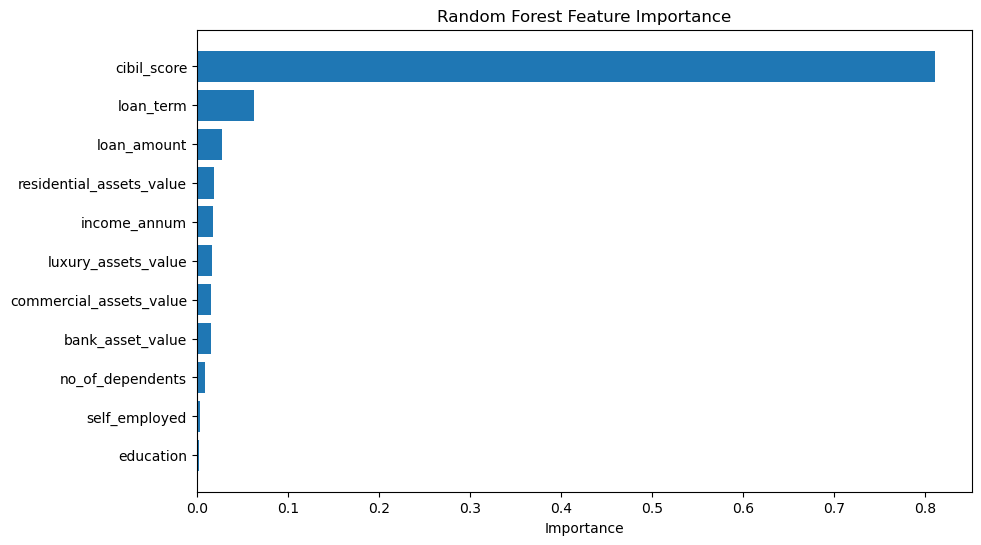

In [37]:
# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.show()

#### ⚠️ Things to pay attention to with Random Forest

-   Random Forest too can overfit! They are less prone to that, though, than decision trees (since they rely average or majority ranking).

-   Slower than decision trees

-   Less interpretable!

-   Trained on a subset of features so immune to curse of dimensionality unlike decision trees


### Boosting

Random Forest are a type of tree ensemble. Other types of tree ensembles include boosted trees like XGBoost (Tianqi Chen and Carlos Guestrin. 2016. XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 785–794. <https://doi.org/10.1145/2939672.2939785>) (which you saw during the lab on Monday) or CatBoost (Liudmila Prokhorenkova, Gleb Gusev, Aleksandr Vorobev, Anna Veronika Dorogush, and Andrey Gulin. 2018. CatBoost: unbiased boosting with categorical features. In Proceedings of the 32nd International Conference on Neural Information Processing Systems (NIPS'18). Curran Associates Inc., Red Hook, NY, USA, 6639–6649.<https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf>).
